# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.
    
    THIS IS MEANT FOR EDUCATIONAL PURPOSES.  The condensed version is in strategy.ipynb

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [13]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [14]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = '^DJI'
#symbol = 'DJA'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Include dividends? (If yes, set to True)

In [15]:
use_adj = True

Fetch symbol data from internet; use cache if available.

In [16]:
ts = pf.fetch_timeseries(symbol)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,43.97,43.75,43.97,43.94,1003200.00,26.18
1993-02-01,44.25,43.97,43.97,44.25,480500.00,26.37
1993-02-02,44.38,44.12,44.22,44.34,201300.00,26.43
1993-02-03,44.84,44.38,44.41,44.81,529400.00,26.71
1993-02-04,45.09,44.47,44.97,45.00,531500.00,26.82


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [17]:
ts = pf.select_tradeperiod(ts, start, end, use_adj)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,26.20,26.07,26.20,26.18,1003200.00,26.18
1993-02-01,26.37,26.20,26.20,26.37,480500.00,26.37
1993-02-02,26.44,26.30,26.35,26.43,201300.00,26.43
1993-02-03,26.72,26.44,26.46,26.71,529400.00,26.71
1993-02-04,26.87,26.50,26.80,26.82,531500.00,26.82


Add technical indicator: 50 day ma and 200 day ma

In [18]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

ts.head()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
1993-01-29,26.20,26.07,26.20,26.18,1003200.00,26.18,nan,nan
1993-02-01,26.37,26.20,26.20,26.37,480500.00,26.37,nan,nan
1993-02-02,26.44,26.30,26.35,26.43,201300.00,26.43,nan,nan
1993-02-03,26.72,26.44,26.46,26.71,529400.00,26.71,nan,nan
1993-02-04,26.87,26.50,26.80,26.82,531500.00,26.82,nan,nan


Finalize the time series before implementing trading strategy

In [19]:
ts, start = pf.finalize_timeseries(ts, start)
ts.head()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
1993-11-11,28.29,28.12,28.21,28.14,88900.00,28.14,28.04,27.18
1993-11-12,28.37,28.18,28.20,28.27,108200.00,28.27,28.05,27.19
1993-11-15,28.33,28.18,28.33,28.25,243300.00,28.25,28.05,27.20
1993-11-16,28.40,28.20,28.31,28.38,492600.00,28.38,28.06,27.21
1993-11-17,28.40,28.16,28.40,28.23,39600.00,28.23,28.07,27.22


Plot closing price along with moving averages

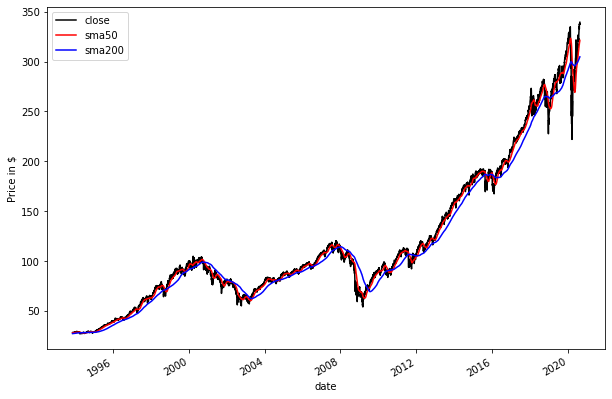

In [20]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [21]:
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [22]:
pf.TradeLog.cash = capital

import time
t0 = time.time()

"""
# This is the slowest (2.42 s)
for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]

# This is still slow (2.53 s)
for i, (index, row) in enumerate(ts.iterrows()):

    date = index
    high = row['high']
    low = row['low']
    close = row['close']
    sma50 = row['sma50']
    sma200 = row['sma200']


# using .at[] is fast (832 ms)
for i, index in enumerate(ts.index):

    date = index
    high = ts.at[index, 'high']
    low = ts.at[index, 'low']
    close = ts.at[index, 'close']
    sma50 = ts.at[index, 'sma50']
    sma200 = ts.at[index, 'sma200']

# using itertuples is fastest for looping (378 ms)
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
"""

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high; low = row.low; close = row.close; 
    end_flag = pf.is_last_row(ts, i)
    shares = 0
    
    # buy
    if tlog.shares == 0:
        if row.sma50 > row.sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1]:
            # enter buy in trade log
            shares = tlog.buy(date, close)  
    # sell
    else:
        if ((row.sma50 < row.sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1])
            or end_flag):
            # enter sell in trade log
            shares = tlog.sell(date, close)

    if shares > 0:
        print("{0} BUY  {1} {2} @ {3:.2f}".format(
              date, shares, symbol, close))
    elif shares < 0:
        print("{0} SELL {1} {2} @ {3:.2f}".format(
              date, -shares, symbol, close))

    # record daily balance
    dbal.append(date, high, low, close)  

t1 = time.time()
total = t1-t0
print(total)
        

1994-09-01 00:00:00 BUY  340 SPY @ 29.38
1998-10-01 00:00:00 SELL 340 SPY @ 66.30
1998-12-04 00:00:00 BUY  283 SPY @ 79.42
2000-11-02 00:00:00 SELL 283 SPY @ 97.82
2002-04-19 00:00:00 BUY  352 SPY @ 78.83
2002-05-17 00:00:00 SELL 352 SPY @ 77.45
2003-05-12 00:00:00 BUY  404 SPY @ 67.39
2004-08-25 00:00:00 SELL 404 SPY @ 80.45
2004-10-27 00:00:00 BUY  396 SPY @ 82.08
2006-07-25 00:00:00 SELL 396 SPY @ 95.24
2006-08-29 00:00:00 BUY  384 SPY @ 98.18
2007-12-28 00:00:00 SELL 384 SPY @ 113.93
2009-06-18 00:00:00 BUY  595 SPY @ 73.57
2010-07-07 00:00:00 SELL 595 SPY @ 86.76
2010-10-13 00:00:00 BUY  532 SPY @ 96.93
2011-08-17 00:00:00 SELL 532 SPY @ 99.81
2012-01-23 00:00:00 BUY  478 SPY @ 111.03
2015-09-03 00:00:00 SELL 478 SPY @ 177.04
2015-12-09 00:00:00 BUY  453 SPY @ 186.87
2016-01-15 00:00:00 SELL 453 SPY @ 171.93
2016-04-20 00:00:00 BUY  403 SPY @ 193.33
2018-12-12 00:00:00 SELL 403 SPY @ 256.37
2019-03-26 00:00:00 BUY  376 SPY @ 274.28
2020-03-31 00:00:00 SELL 376 SPY @ 256.62
2020-07

Retrieve raw log and trade log DataFrames

In [23]:
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [24]:
rlog.tail()

,date,seq_num,price,shares,entry_exit,direction,symbol
21,2018-12-12,21,256.37,403,exit,LONG,SPY
22,2019-03-26,22,274.28,376,entry,LONG,SPY
23,2020-03-31,23,256.62,376,exit,LONG,SPY
24,2020-07-06,24,317.05,305,entry,LONG,SPY
25,2020-08-21,25,339.48,305,exit,LONG,SPY


In [25]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
3,2003-05-12,67.39,2004-08-25,80.45,13.06,5275.34,404,22547.36,LONG,SPY
4,2004-10-27,82.08,2006-07-25,95.24,13.16,5211.51,396,27758.87,LONG,SPY
5,2006-08-29,98.18,2007-12-28,113.93,15.74,6045.36,384,33804.23,LONG,SPY
6,2009-06-18,73.57,2010-07-07,86.76,13.19,7847.70,595,41651.93,LONG,SPY
7,2010-10-13,96.93,2011-08-17,99.81,2.88,1530.95,532,43182.88,LONG,SPY
8,2012-01-23,111.03,2015-09-03,177.04,66.01,31551.42,478,74734.30,LONG,SPY
9,2015-12-09,186.87,2016-01-15,171.93,-14.94,-6765.93,453,67968.38,LONG,SPY
10,2016-04-20,193.33,2018-12-12,256.37,63.04,25405.94,403,93374.32,LONG,SPY
11,2019-03-26,274.28,2020-03-31,256.62,-17.66,-6641.38,376,86732.94,LONG,SPY
12,2020-07-06,317.05,2020-08-21,339.48,22.43,6841.16,305,93574.10,LONG,SPY


In [26]:
dbal = dbal.get_log(tlog)
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-08-17,103226.39,102771.94,103095.24,305,32.69,1.00,-
2020-08-18,103458.19,102698.74,103317.90,305,32.69,1.00,-
2020-08-19,103613.74,102701.79,102887.85,305,32.69,1.00,-
2020-08-20,103366.69,102274.79,103208.09,305,32.69,1.00,-
2020-08-21,103574.10,103574.10,103574.10,0,103574.10,1.00,X


Generate strategy stats - display all available stats

In [27]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2020-08-21
beginning_balance                                            10000
ending_balance                                           103574.10
total_net_profit                                          93574.10
gross_profit                                             107468.14
gross_loss                                               -13894.04
profit_factor                                                 7.73
return_on_initial_capital                                   935.74
annual_return_rate                                            9.12
trading_period                           26 years 9 months 10 days
pct_time_in_market                                           74.18
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Run Benchmark

In [28]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj)
benchmark.run()

1993-11-11 00:00:00 BUY  355 SPY @ 28.14
2020-08-21 00:00:00 SELL 355 SPY @ 339.48


Retrieve benchmark logs

In [29]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [30]:
benchmark.stats = benchmark.get_stats()

Plot Equity Curves: Strategy vs Benchmark

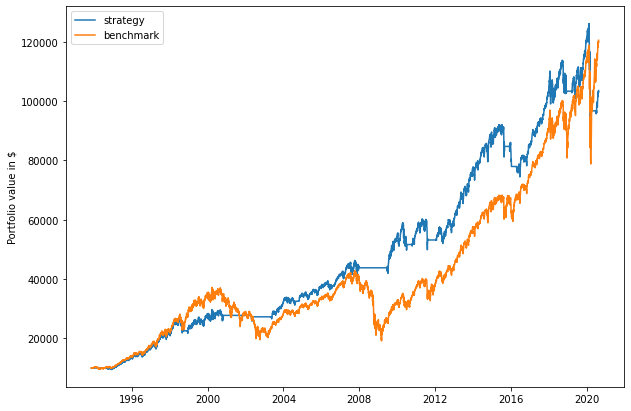

In [31]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

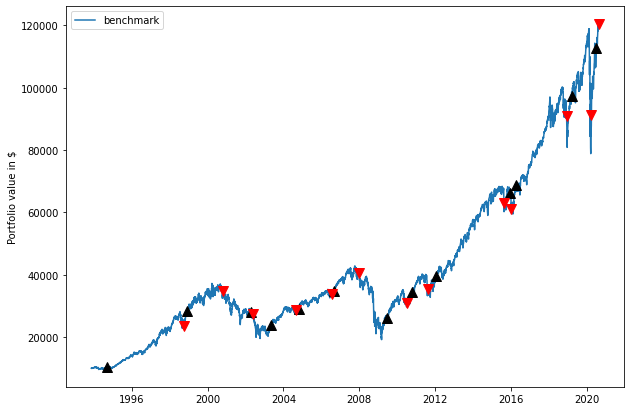

In [32]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [33]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$103,574.10","$120,526.34"
total_net_profit,"$93,574.10","$110,526.34"
gross_profit,"$107,468.14","$110,526.34"
gross_loss,"-$13,894.04",$0.00


,strategy,benchmark
annual_return_rate,9.12,9.74
max_closed_out_drawdown,-33.65,-55.18
drawdown_annualized_return,-3.69,-5.66
drawdown_recovery,-0.09,-1.42
best_month,15.56,23.61
worst_month,-30.93,-30.98
sharpe_ratio,0.71,0.58
sortino_ratio,0.75,0.74
monthly_std,3.26,4.54
annual_std,11.93,16.91


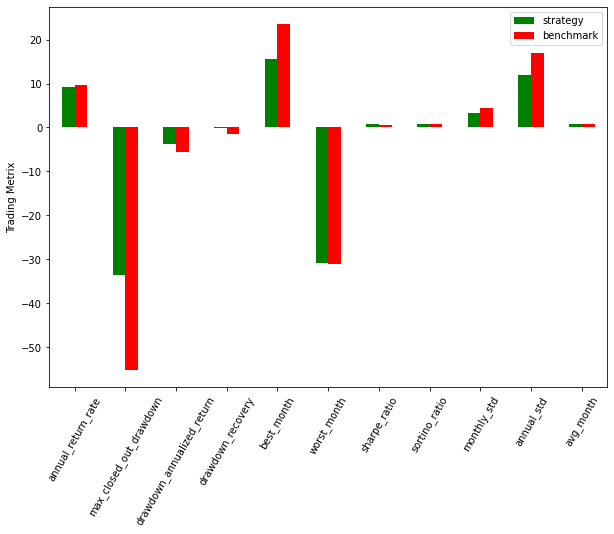

In [34]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df